In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import torch.optim as optim
import shap
import numpy as np
import matplotlib.pyplot as plt

**DATASET - D, FOR DATA UNDERSTANDING**

DATA LOADING AND DIRECTORY PLANNING 

For this particular dataset based on the provided info instructions on the dataset website : http://www.am.sanken.osaka-u.ac.jp/BiometricDB/GaitTM.html,  we have made a custom csv to load the data

| Directory   | Labels_1 | Labels_2 |
|-------------|----------|----------|
| 00001M400000| High     |          |
| 00001M400001| High     |          |
| 00002M400000| Low      |          |
| 00002M400001| Low      |          |
| 00003M000000| High     | Low      |
| 00003M000001| High     | Low      |


In [1]:
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    image_paths =[]
    labels =[]
    for _,row in df.iterrows():
        folder_path= os.path.join(DIRECTORY_PATH,row['Directory'])
        label = [row['Labels_1'],row['Labels_2']]  
        for img_filename in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path,img_filename))
            labels.append(label)
    return image_paths,labels

def count_images(csv_path, directory_path):
    df = pd.read_csv(csv_path)
    total_images = 0
    for directory in df['Directory'].unique():
        folder_path = os.path.join(directory_path, directory)
        total_images += len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
    return total_images

DIRECTORY_PATH ='TreadmillDatasetD'
CSV_PATH ='ref.csv'
total_images_count = count_images(CSV_PATH,DIRECTORY_PATH)
print(f"Total number of images: {total_images_count } ")


Total number of images: 2137


DATASET VISUALS

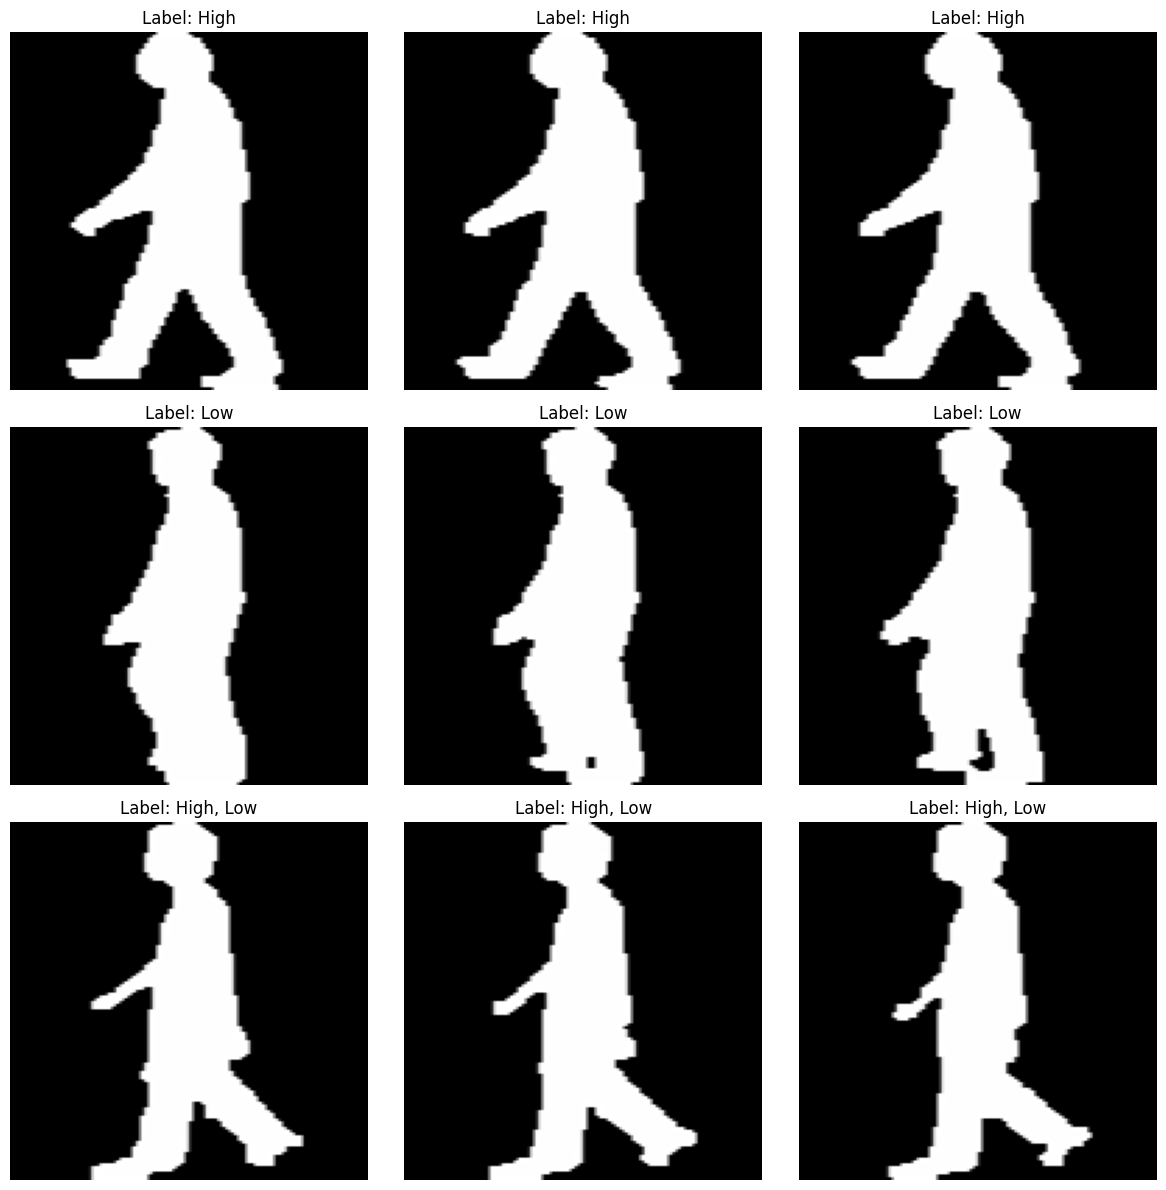

In [2]:
def plot_sample_images(directory_path, csv_path, num_samples=3):
    df = pd.read_csv(csv_path)
    df['Labels_1'] = df['Labels_1'].fillna('')
    df['Labels_2'] = df['Labels_2'].fillna('')
    df['Label'] = df[['Labels_1','Labels_2']].apply(lambda x: ', '.join(filter(None, x)), axis=1)
    labels = df['Label'].unique() 
    if len(labels) == 0: 
        # print("No labels found")
        return
    fig, axs = plt.subplots(len(labels), num_samples, figsize=(num_samples *4, len(labels)*4))
    if len(labels) == 1:axs =[axs]
    for i,label in enumerate(labels):
        relevant_dirs=df[df['Label'] ==label]['Directory'].unique()
        sample_images =[]
        for dir_name in relevant_dirs:
            dir_path = os.path.join(directory_path, dir_name)
            image_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.lower().endswith(('.png'))]
            sample_images.extend(image_files)
            if len(sample_images) >=num_samples:break
        sample_images = sample_images[:num_samples]
        for j, image_path in enumerate(sample_images):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128,128))
            ax = axs[i] if num_samples ==1 else axs[i, j]
            ax.imshow(image, cmap='gray')
            ax.set_title(f'Label: {label}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()
DIRECTORY_PATH='TreadmillDatasetD'
CSV_PATH='ref.csv'
plot_sample_images(DIRECTORY_PATH, CSV_PATH)


SINCE THE OFFICIAL DATASET HAS FEWER SAMPLES AND ATTRIBUTES, BUILDING A FUNCTION BASED ON THE PAPER : https://www.jstage.jst.go.jp/article/ipsjtcva/4/0/4_0_53/_pdf , FOR HAVING AN ESTIMATION OF NAC (NORMALIZED AUTO CORRELATION) VALUES FOR FUTURE RESEARCH AND EXPRIMENTATION AS THIS APPROACH HAS PROMISED POSITIVE OUTLOOK FOR EXPLORING 

NAC - CALCULATIONS AND ESTIMATION

In [3]:
import numpy as np
from PIL import Image
import os

def load_silhouettes(subject_id, base_path, num_frames):
    silhouettes = []
    for i in range(1, num_frames + 1):
        image_path = os.path.join(base_path, subject_id, f'{i:08d}.png')
        image = Image.open(image_path).convert('L') 
        silhouettes.append(np.array(image))
    return np.array(silhouettes)

def compute_nac(silhouettes, N_min, N_max):
    N_total = silhouettes.shape[0]
    #x_dim, y_dim = silhouettes.shape[1],silhouettes.shape[2]
    NAC_values = {}
    for N in range(N_min, N_max + 1):
        sum_xy=0
        sum_gx2=0
        sum_gy2=0
        for n in range(N_total - N):
            g_x =silhouettes[n]
            g_y=silhouettes[n + N]
            sum_xy += np.sum(g_x*g_y)
            sum_gx2 += np.sum(g_x**2)
            sum_gy2 += np.sum(g_y**2)
        T_N = N_total - N - 1
        denominator = np.sqrt(sum_gx2*sum_gy2)
        NAC = sum_xy /denominator if denominator != 0 else 0
        NAC_values[N] = NAC
    return NAC_values

def find_optimal_shift(NAC_values):
    optimal_shift = max(NAC_values,key=NAC_values.get)
    return optimal_shift, NAC_values[optimal_shift]

base_path ='TreadmillDatasetD'
subject_id ='00001M400000'
num_frames =360
N_min = 50 
N_max = 78
silhouettes=load_silhouettes(subject_id, base_path, num_frames)
NAC_values=compute_nac(silhouettes, N_min, N_max)
optimal_shift,max_NAC=find_optimal_shift(NAC_values)
print(f'Optimal Shift: {optimal_shift}, Max NAC: {max_NAC}')

Optimal Shift: 69, Max NAC: 0.9748383230760724


COMPLETE EXPERIMENTATION

c:\Users\smart\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1: Train Loss: 0.9014
Validation AUC: 0.9870
Epoch 2: Train Loss: 0.6161
Validation AUC: 0.9906
Epoch 3: Train Loss: 0.4686
Validation AUC: 0.9997
Epoch 4: Train Loss: 0.3022
Validation AUC: 1.0000
Epoch 5: Train Loss: 0.1340
Validation AUC: 1.0000


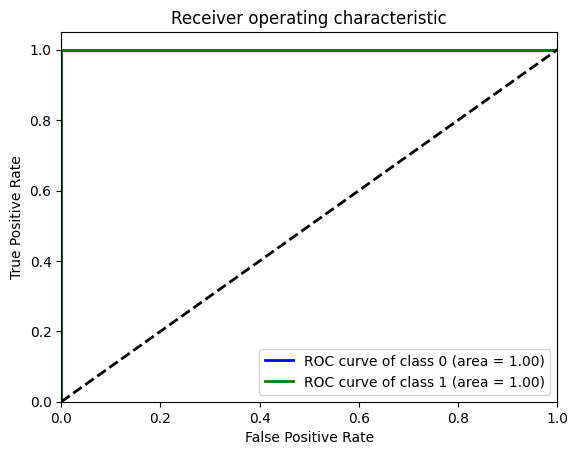

Confusion Matrix:
[[246   0]
 [  2 137]]


In [4]:
DIRECTORY_PATH = 'TreadmillDatasetD'
CSV_PATH = 'ref.csv'
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
CHANNELS = 1 
BATCH_SIZE = 32
EPOCHS = 10

def load_data(csv_path):
    df = pd.read_csv(csv_path)
    image_paths = []
    labels = []
    for _, row in df.iterrows():
        folder_path = os.path.join(DIRECTORY_PATH, row['Directory'])
        label = [row['Labels_1'], row['Labels_2']]
        for img_filename in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path, img_filename))
            labels.append(label)
    return image_paths, labels

from torch.utils.data import Dataset
import cv2
import torch

class GaitDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):return len(self.image_paths)
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))
        if self.transform:
            image = self.transform(image)
        label_tensor = torch.zeros(2) 
        labels = self.labels[index]
        if 'High' in labels:label_tensor[0] = 1
        if 'Low' in labels:label_tensor[1] = 1
        return image, label_tensor
    
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1=nn.Conv2d(1,32, kernel_size=3, padding=1)
        self.pool =nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(32,64, kernel_size=3, padding=1)
        input_size = (128,128) 
        output_size =self.calculate_conv_output_size(input_size, 3, 1, 1) 
        output_size =self.calculate_conv_output_size(output_size, 2, 0, 2)  
        output_size =self.calculate_conv_output_size(output_size, 3, 1, 1) 
        output_size =self.calculate_conv_output_size(output_size, 2, 0, 2)
        linear_input_size = output_size[0]*output_size[1]*64
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(linear_input_size, 64)
        self.fc2 = nn.Linear(64, 2)
    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x =self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def calculate_conv_output_size(self, input_size, kernel_size, padding, stride):
        output_height = ((input_size[0] + 2 *padding - kernel_size)//stride)+1
        output_width = ((input_size[1] + 2 *padding - kernel_size)//stride)+1
        return (output_height,output_width)
    
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
EPOCHS = 5

image_paths, labels = load_data('ref.csv')
trainval_paths, test_paths, trainval_labels, test_labels = train_test_split(image_paths,labels,test_size=0.1,random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(trainval_paths,trainval_labels,test_size=0.2,random_state=42)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])
train_dataset = GaitDataset(train_paths, train_labels, transform=transform)
val_dataset = GaitDataset(val_paths, val_labels, transform=transform)
test_dataset = GaitDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = CNN().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def evaluate_model(loader, model):
    model.eval()
    y_true, y_pred = [],[]
    with torch.no_grad():
        for images,labels in loader:
            images,labels=images.to(DEVICE),labels.to(DEVICE)
            outputs=model(images)
            y_true.append(labels.cpu())
            y_pred.append(torch.sigmoid(outputs).cpu())
    y_true=torch.cat(y_true, dim=0).numpy()
    y_pred=torch.cat(y_pred, dim=0).numpy()
    return y_true,y_pred

for epoch in range(EPOCHS):
    model.train()
    train_loss=0.0
    for images,labels in train_loader:
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss +=loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}')
    y_true, y_pred = evaluate_model(val_loader, model)
    auc_score = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    print(f'Validation AUC: {auc_score:.4f}')

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(n_classes):
    fpr[i],tpr[i],_ = roc_curve(y_true[:,i],y_pred[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])

colors = cycle(['blue','green'])
for i, color in zip(range(n_classes),colors):
    plt.plot(fpr[i],tpr[i],color=color,lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

y_pred_bin = (y_pred>0.5).astype(int)
cm = confusion_matrix(y_true.argmax(axis=1),y_pred_bin.argmax(axis=1))
print("Confusion Matrix:")
print(cm)

Epoch 1: Train Loss: 1.2054, Test Accuracy: 0.3505
Epoch 2: Train Loss: 0.6211, Test Accuracy: 0.3178
Epoch 3: Train Loss: 0.5339, Test Accuracy: 0.6168
Epoch 4: Train Loss: 0.2900, Test Accuracy: 0.7617
Epoch 5: Train Loss: 0.1675, Test Accuracy: 0.8972
Epoch 6: Train Loss: 0.0958, Test Accuracy: 1.0000
Epoch 7: Train Loss: 0.0343, Test Accuracy: 1.0000
Epoch 8: Train Loss: 0.0121, Test Accuracy: 1.0000
Epoch 9: Train Loss: 0.0056, Test Accuracy: 0.9907
Epoch 10: Train Loss: 0.0045, Test Accuracy: 1.0000


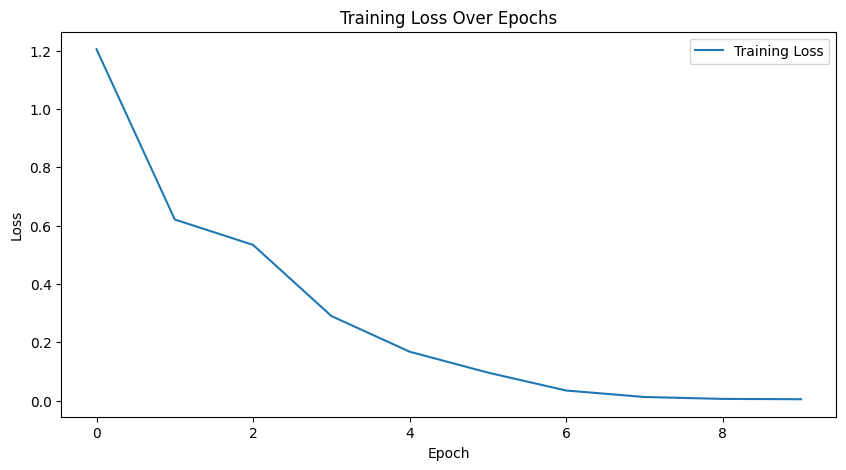

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
EPOCHS = 10
image_paths, labels = load_data('ref.csv')
trainval_paths, test_paths, trainval_labels, test_labels = train_test_split(image_paths,labels, test_size=0.1, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(trainval_paths, trainval_labels, test_size=0.2, random_state=42)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])
train_dataset = GaitDataset(train_paths, train_labels, transform=transform)
test_dataset = GaitDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = CNN().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
def evaluate_model(loader, model):
    model.eval()
    total,correct=0,0
    with torch.no_grad():
        for images,labels in loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            predicted = torch.sigmoid(outputs).data>0.5
            total += labels.size(0)
            correct += (predicted==labels).all(dim=1).sum().item()
    return correct/total
train_losses = []
test_losses = []
for epoch in range(EPOCHS):
    model.train()
    train_loss=0.0
    for images,labels in train_loader:
        images,labels =images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs =model(images)
        loss =criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*images.size(0)
    train_loss /=len(train_loader.dataset)
    train_losses.append(train_loss)
    test_accuracy = evaluate_model(test_loader, model)
    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

SHAP - ANALYSIS ON CONVOLUTIONAL LEARNING AND FEATURE MAP UNDERSTANDING 

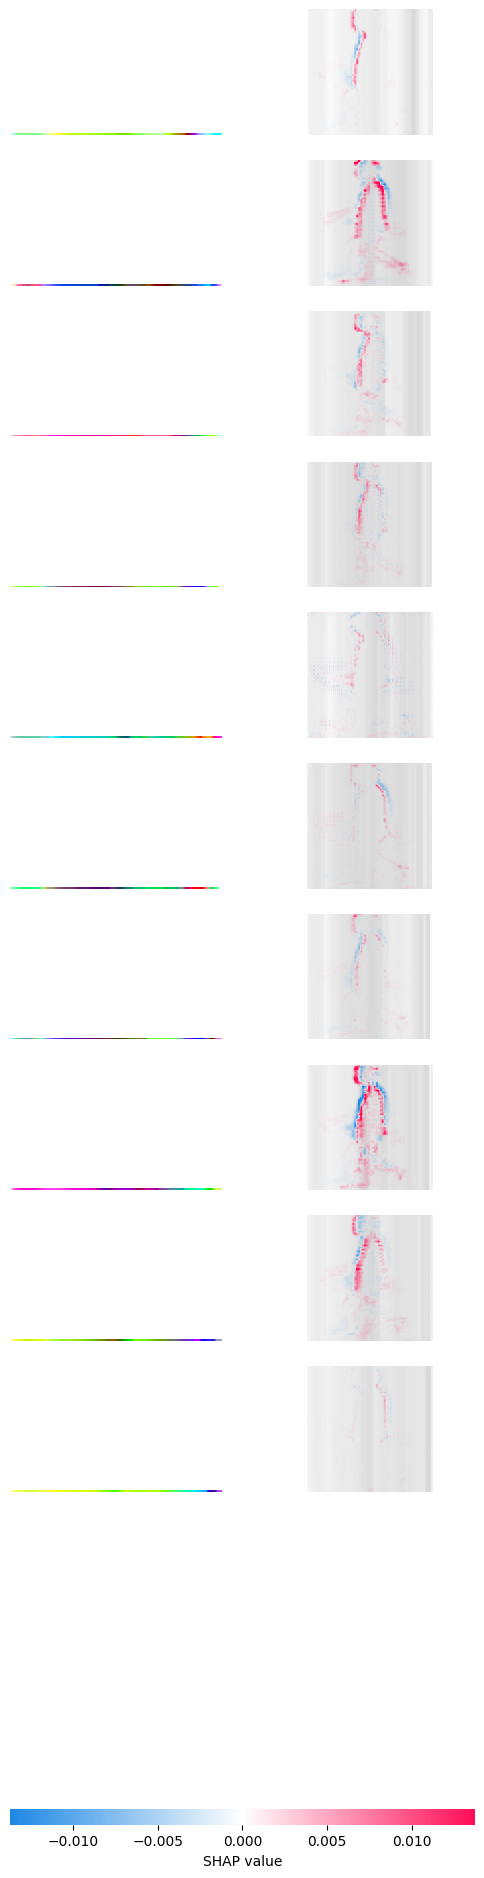

In [8]:
data,labels = next(iter(test_loader))
data = data.to(DEVICE)
layer = model.conv2  
explainer = shap.GradientExplainer((model,layer),data)
shap_values = explainer.shap_values(data,nsamples=50) 
if len(shap_values)>0 and len(data)>0:
    class_idx =0
    max_display =min(len(data), 10)
    shap_numpy =np.array(shap_values[class_idx])
    display_data =-data.cpu().numpy()
    shap.image_plot(shap_numpy[:max_display], display_data[:max_display])
else:
    # print("")
